# Federated Learning
 **is a machine learning technique that allows multiple decentralized devices or servers to collaboratively train a model without sharing their data. Instead of gathering all data in a central location, FL trains models locally on each device and then aggregates the learned updates (such as model weights) in a secure and privacy-preserving manner. This approach is particularly useful in scenarios where data privacy, security, or bandwidth limitations prevent direct access to data.**

### Server Sending models to banks

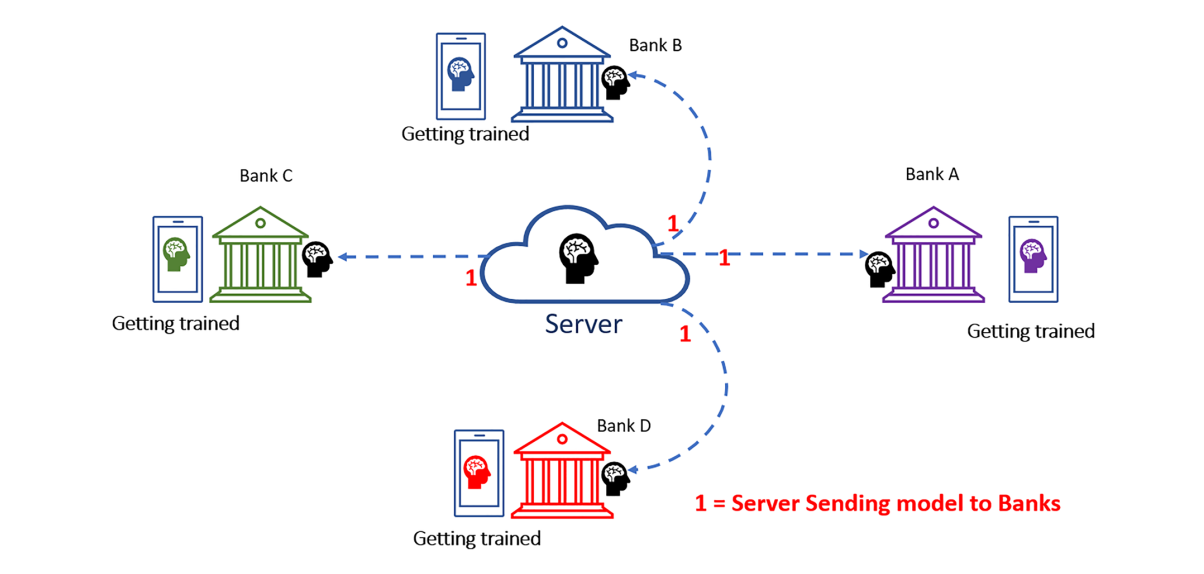

### Trained models sent from Banks

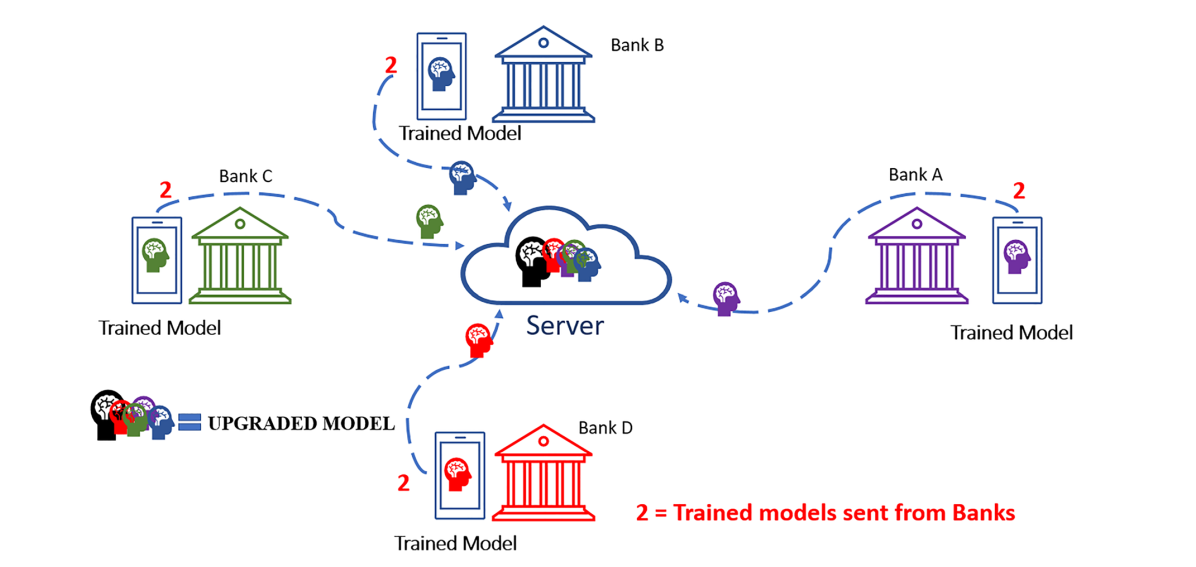

### Server Sending upgraded model to banks

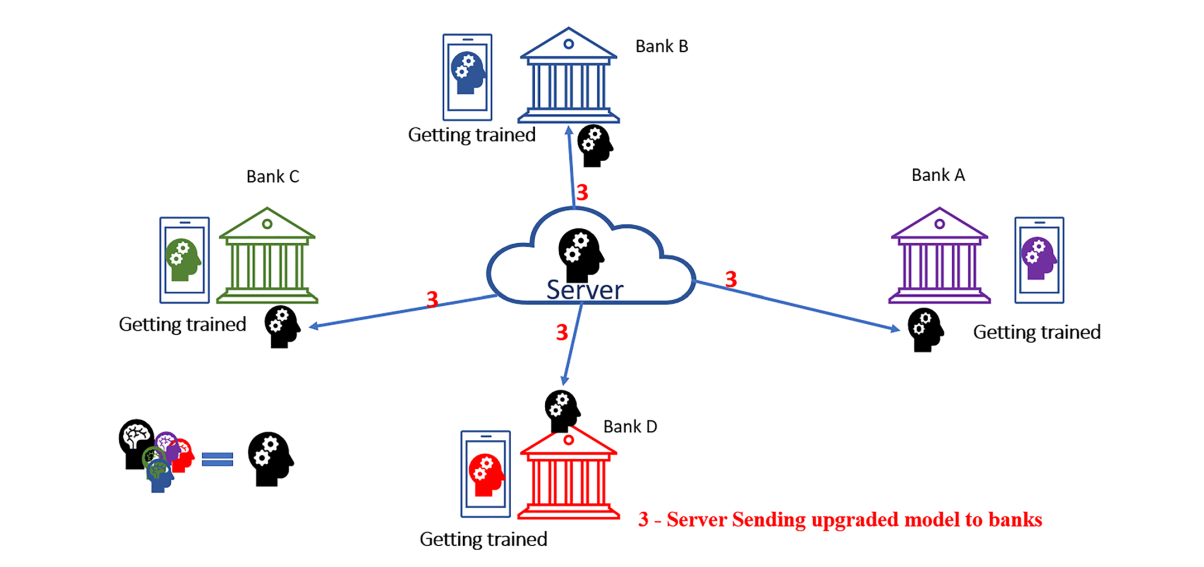

### Summary

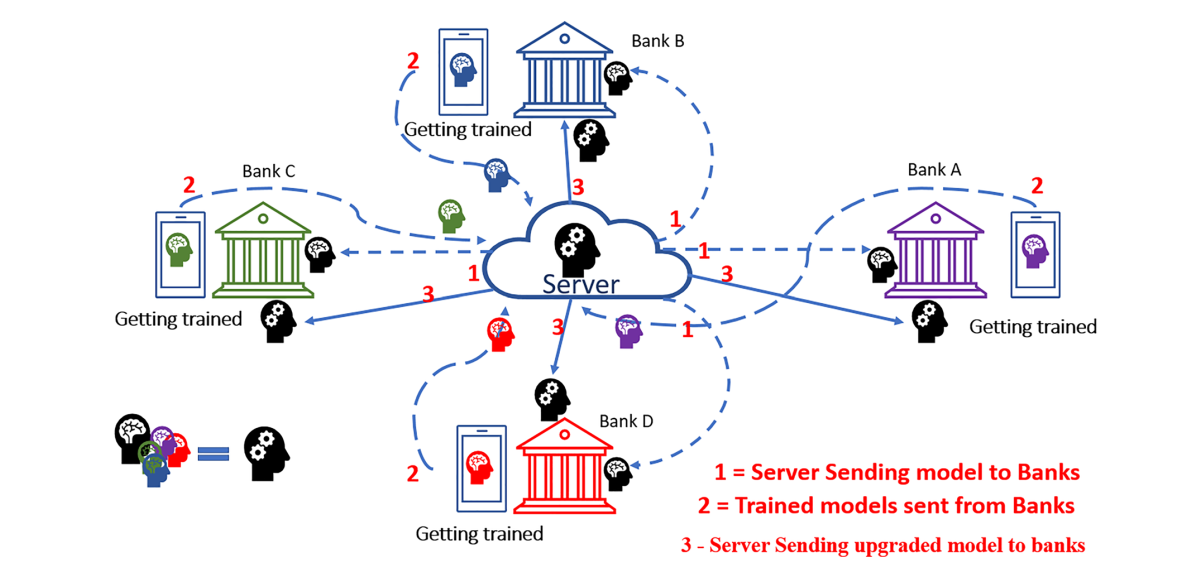

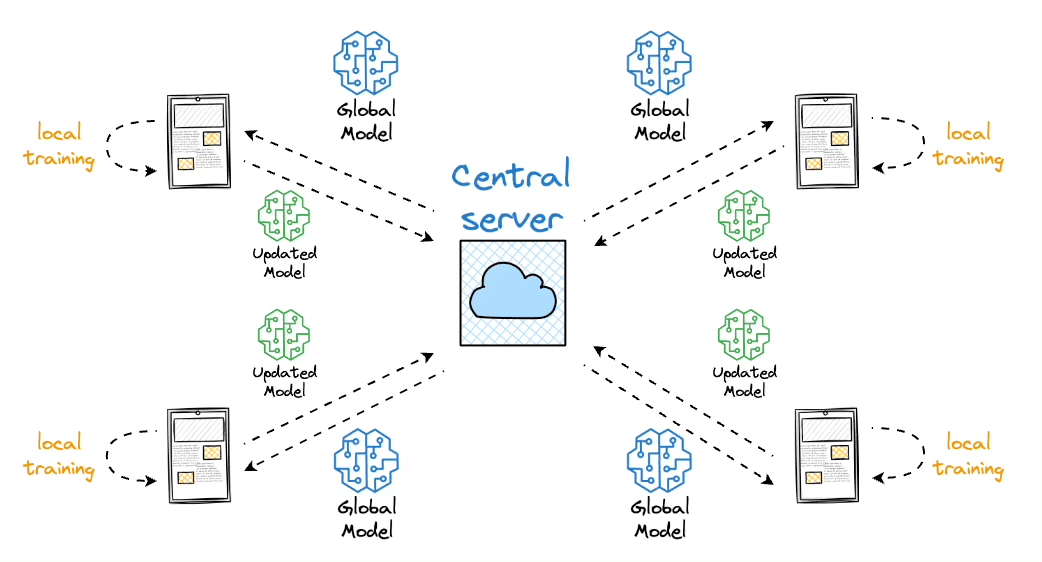

In [99]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [100]:
!pip install imutils
from imutils import paths

In [101]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def load(paths, verbose=-1):
    '''expects CSV files, with rows as transaction data and labels in the last column.'''
    data = list()
    labels = list()

    # Loop over the CSV files and load the data
    for (i, csvpath) in enumerate(paths):
        df = pd.read_csv(csvpath)
        label = df.iloc[:, -1].values
        features = df.iloc[:, :-1].values
        
        # Scale the features to [0, 1] using standard scaling
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        data.extend(features_scaled)
        labels.extend(label)

        # Show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))

    # Convert data and labels to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    
    # Only apply SMOTE to the fraud (minority) class
    fraud_class_count = np.sum(labels == 1)
    non_fraud_class_count = len(labels) - fraud_class_count

    print(f"Before SMOTE: Fraud class - {fraud_class_count}, Non-fraud class - {non_fraud_class_count}")

    if fraud_class_count < non_fraud_class_count:
        # Apply SMOTE only for the fraud class
        smote = SMOTE(sampling_strategy='minority', random_state=42)
        data_resampled, labels_resampled = smote.fit_resample(data, labels)
        
        print(f"After SMOTE: Fraud class - {np.sum(labels_resampled == 1)}, Non-fraud class - {np.sum(labels_resampled == 0)}")
    else:
        print("No need for SMOTE as the fraud class is not the minority.")
        data_resampled, labels_resampled = data, labels
    
    return data_resampled, labels_resampled

def create_clients(data, labels, num_clients=10, initial='clients'):
    '''Return: a dictionary with keys as clients' names and value as data shards - tuple of features and labels.'''
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    # Randomize the data
    data_labels = list(zip(data, labels))
    random.shuffle(data_labels)

    # Shard data and assign to each client
    size = len(data_labels) // num_clients
    shards = [data_labels[i:i + size] for i in range(0, size * num_clients, size)]

    # Ensure number of clients matches number of data shards
    assert(len(shards) == len(client_names))

    return {client_names[i]: shards[i] for i in range(len(client_names))}

def batch_data(data_shard, bs=32):
    '''Create a tf.data.Dataset object from a client's data shard.'''
    # Separate shard into data and labels
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    # Get the batch size from the client's training data
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    
    # Calculate the total training data points across all clients
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names]) * bs
    
    # Get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() * bs
    
    return local_count / global_count

def scale_model_weights(weight, scalar):
    '''Scale a model's weights by a scalar value.'''
    return [scalar * w for w in weight]

def sum_scaled_weights(scaled_weight_list):
    '''Sum the scaled weights across clients.'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad

def test_model(X_test, Y_test, model, comm_round):
    # Predict the logits
    logits = model.predict(X_test)
    
    # Check for NaN or infinity in logits and Y_test
    if np.any(np.isnan(logits)) or np.any(np.isinf(logits)) or np.any(np.isnan(Y_test)) or np.any(np.isinf(Y_test)):
        print(f"NaN or Inf detected in logits or Y_test at communication round {comm_round}")
        return 0, 0
    
    # Round the logits to binary values (0 or 1) for binary classification
    predicted_labels = tf.round(logits)
    
    # Compute accuracy score
    try:
        acc = accuracy_score(Y_test, predicted_labels.numpy())
        bce_loss = tf.keras.losses.BinaryCrossentropy()
        loss = bce_loss(Y_test, logits).numpy()
    except Exception as e:
        print(f"Error in accuracy or loss calculation: {e}")
        acc, loss = 0, 0

    # Print the results for each communication round
    print(f'comm_round: {comm_round} | global_acc: {acc:.3%} | global_loss: {loss}')
    
    return acc, loss



In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import LearningRateScheduler
class SimpleMLP:
    @staticmethod
    def build(shape):
        model = Sequential()

        # First hidden layer
        model.add(Dense(512, input_shape=(shape,), kernel_initializer=HeNormal()))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))  # Dropout to prevent overfitting

        # Second hidden layer
        model.add(Dense(256, kernel_initializer=HeNormal()))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Third hidden layer
        model.add(Dense(128, kernel_initializer=HeNormal()))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Fourth hidden layer
        model.add(Dense(64, kernel_initializer=HeNormal()))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Output layer
        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        # Compile the model with Adam optimizer and binary crossentropy loss
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        return model

In [103]:
data_path = '/kaggle/input/creditcardfraud'
csv_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.csv')]

# Load data
X, y = load(csv_paths)

# Binarize the labels (fraud = 1, not fraud = 0)
lb = LabelBinarizer()
y = lb.fit_transform(y)

Before SMOTE: Fraud class - 492, Non-fraud class - 284315
After SMOTE: Fraud class - 284315, Non-fraud class - 284315


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train

array([[ 1.25219225e+00, -2.76243789e-02, -2.34505547e+00, ...,
        -4.14688187e-01,  3.79042911e-01,  3.97193531e+00],
       [-7.94640765e-01, -3.71611759e-01, -3.08977277e-01, ...,
        -3.20023423e-01, -2.73979816e-01,  1.33723099e+00],
       [-2.00863022e-02, -5.53955373e+00,  4.07402807e+00, ...,
        -3.62862905e+00, -1.24720817e+00, -4.13786698e-02],
       ...,
       [-8.66488997e-01, -2.82520498e+00,  3.80413353e-01, ...,
         3.85806184e+00,  1.14950320e+00, -3.49231307e-01],
       [-3.16265999e-01, -7.48504091e-02,  6.01309700e-01, ...,
        -3.00123029e-01, -5.94382369e-01, -3.37476933e-01],
       [-3.88157751e-01,  6.29590625e-01, -4.75290862e-01, ...,
         3.01406563e-03,  1.16903712e-01,  9.85543469e-02]])

### IID

In [105]:
len(X_train), len(X_test), len(y_train), len(y_test)

(511767, 56863, 511767, 56863)

In [106]:
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [108]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [109]:
lr = 0.01
comms_round = 50
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [110]:
# Initialize global model for Credit Fraud Detection

# Set build_shape to the number of features in your dataset
build_shape = X_train.shape[1]

# Create a SimpleMLP object
smlp_global = SimpleMLP()

# For binary classification (fraud detection), change output units to 1 and activation to 'sigmoid'
global_model = smlp_global.build(build_shape)

# Compile the model for binary classification (using binary cross-entropy loss)
global_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Lists to track global accuracy and loss across communication rounds
global_acc_list = []
global_loss_list = []


In [111]:
# Define loss, optimizer, and metrics for binary classification
loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']

# Commence global training loop
for comm_round in range(comms_round):
    
    # Get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    # Initialize list to collect local model weights after scaling
    scaled_local_weight_list = list()

    # Randomize client data - using keys
    all_client_names = list(clients_batched.keys())
    client_names = random.sample(all_client_names, k=10)
    random.shuffle(client_names)
    
    # Loop through each client and create a new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape)
        local_model.compile(loss=loss, 
                            optimizer=optimizer, 
                            metrics=metrics)
        
        # Set local model weights to the global model's weights
        local_model.set_weights(global_weights)
        
        # Fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        # Scale the model weights and add them to the list
        scaling_factor = 0.1  # Adjust this as needed
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        # Clear session to free memory after each communication round
        K.clear_session()
    
    # To get the average over all the local models, we sum the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    # Update global model with the averaged weights
    global_model.set_weights(average_weights)

    # Test the global model and print out metrics after each communication round
    for X_test, Y_test in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)


comm_round: 0 | global_acc: 93.512% | global_loss: 0.17533297836780548
comm_round: 1 | global_acc: 93.854% | global_loss: 0.15210658311843872
comm_round: 2 | global_acc: 94.281% | global_loss: 0.13124606013298035
comm_round: 3 | global_acc: 94.707% | global_loss: 0.12196239084005356
comm_round: 4 | global_acc: 94.835% | global_loss: 0.11751188337802887
comm_round: 5 | global_acc: 95.336% | global_loss: 0.11232834309339523
comm_round: 6 | global_acc: 95.523% | global_loss: 0.10718131810426712
comm_round: 7 | global_acc: 95.677% | global_loss: 0.10563777387142181
comm_round: 8 | global_acc: 95.992% | global_loss: 0.1011481061577797
comm_round: 9 | global_acc: 96.085% | global_loss: 0.09849104285240173
comm_round: 10 | global_acc: 96.310% | global_loss: 0.094293512403965
comm_round: 11 | global_acc: 96.477% | global_loss: 0.09328746795654297
comm_round: 12 | global_acc: 96.659% | global_loss: 0.08873086422681808
comm_round: 13 | global_acc: 96.798% | global_loss: 0.0866699367761612
comm_r

IID | total comm rounds 50


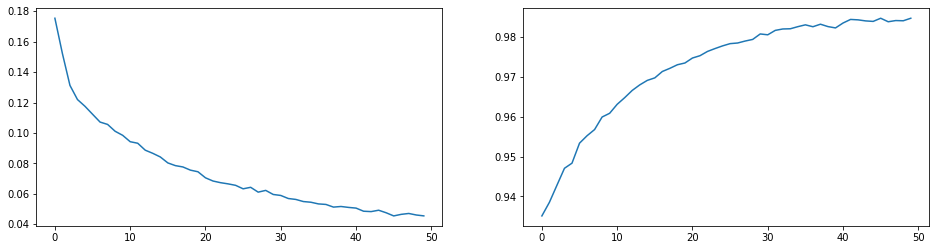

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('IID | total comm rounds', len(global_acc_list))